### Import dataset

In [1]:
data <- read.csv("~/Documents/jupyter-workplace/laser-anoxia/microglia-morphology/data-processing/_m/features_data.csv")
head(data)

Animal,Corte,Grupo,Region,Foreground.pixels.by.hull.area,Hull.Area,Diameter.of.Bounding.Circle,Mean.Radius,Cell.Area,Cell.Perimeter,...,Hull.void.area,Branches,Junctions,End.point.voxels,Triple.points,Quadruple.points,Average.branch.length,Maximum.branch.length,D,Lacunarity
CS2,1,CS,CA1,0.5968,2282,74.9667,31.5814,1362,344.416,...,920,15,7,9,7,0,13.283,29.556,1140,801
CS2,1,CS,CA1,0.8191,376,32.8571,14.7844,308,91.983,...,68,3,1,3,1,0,13.876,22.142,41,1246
CS2,1,CS,CA1,0.4057,2036,78.4092,32.8051,826,246.635,...,1210,7,3,5,3,0,17.840,34.627,87,1271
CS2,1,CS,CA1,0.4576,2380,69.3097,30.9999,1089,341.061,...,1291,20,11,7,11,0,10.674,27.385,429,1659
CS2,1,CS,CA1,0.4241,2457,70.9627,32.7330,1042,371.588,...,1415,18,9,9,9,0,12.222,20.071,585,1452
CS2,1,CS,CA1,0.2993,5362,119.4364,50.7948,1605,709.720,...,3757,40,19,20,17,1,10.588,31.799,538,1596


In [2]:
# silence function
shhh <- function(x){
    suppressPackageStartupMessages(suppressWarnings(x))
    }

## Clustering with optimun configuration

k = 3
Circularity
Endpoints
Hull Area
Cell Perimeter

In [33]:
shhh(library(tidyverse))

# filter data
id.data       <- data[,1:4]
variable.data <- data %>% select(Circularity,End.point.voxels,Hull.Area,Cell.Perimeter)

# pca
pca.data <- prcomp(variable.data, center = TRUE, scale = TRUE)
pca.x    <- pca.data$x[,1:2]

# clustering
clust.data <- hclust(dist(pca.x,method = "euclidian"), method = "ward.D2")
clust.id   <- as.factor(cutree(clust.data,k=3))

[1] 2160

#### Dendrogram

Warning message in `labels<-.dendrogram`(dend, value = value, ...):
“The lengths of the new labels is shorter than the number of leaves in the dendrogram - labels are recycled.”Warning message in rep(new_labels, length.out = leaves_length):
“'x' is NULL so the result will be NULL”

integer(0)

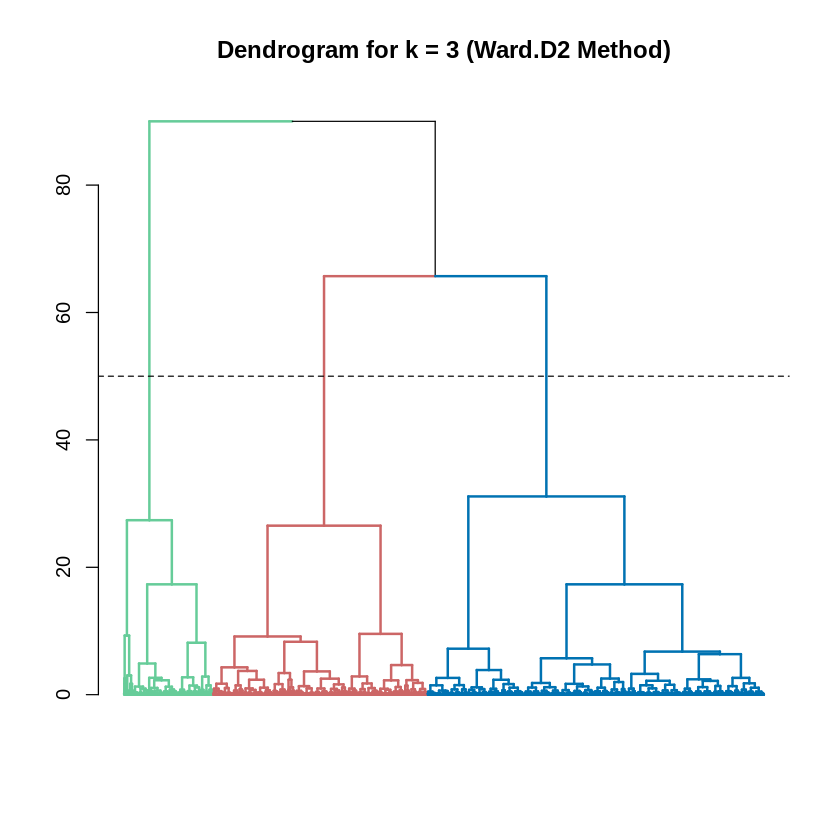

In [4]:
shhh(library(dendextend))

colbranches <- function(n, col){
  a <- attributes(n) # Find the attributes of current node
  # Color edges with requested color
  attr(n, "edgePar") <- c(a$edgePar, list(col=col, lwd=2))
  n # Don't forget to return the node!
  }

title <- "Dendrogram for k = 3 (Ward.D2 Method)"

dend <- clust.data %>%  
  as.dendrogram() %>% set("labels", NULL)

dend[[1]] = dendrapply(dend[[1]], colbranches, "#66CC99")
dend[[2]][[1]] = dendrapply(dend[[2]][[1]], colbranches, "#CC6666")
dend[[2]][[2]] = dendrapply(dend[[2]][[2]], colbranches, "#0072B2")

#plot(dend, main = title)
plot(dend, main = title, type = "rectangle") + abline(h = 50, lty = 2)

rm(title)

#### PCA

In [5]:
# had some problems installing the package so I called the function manualy
source("ggbiplot.R")

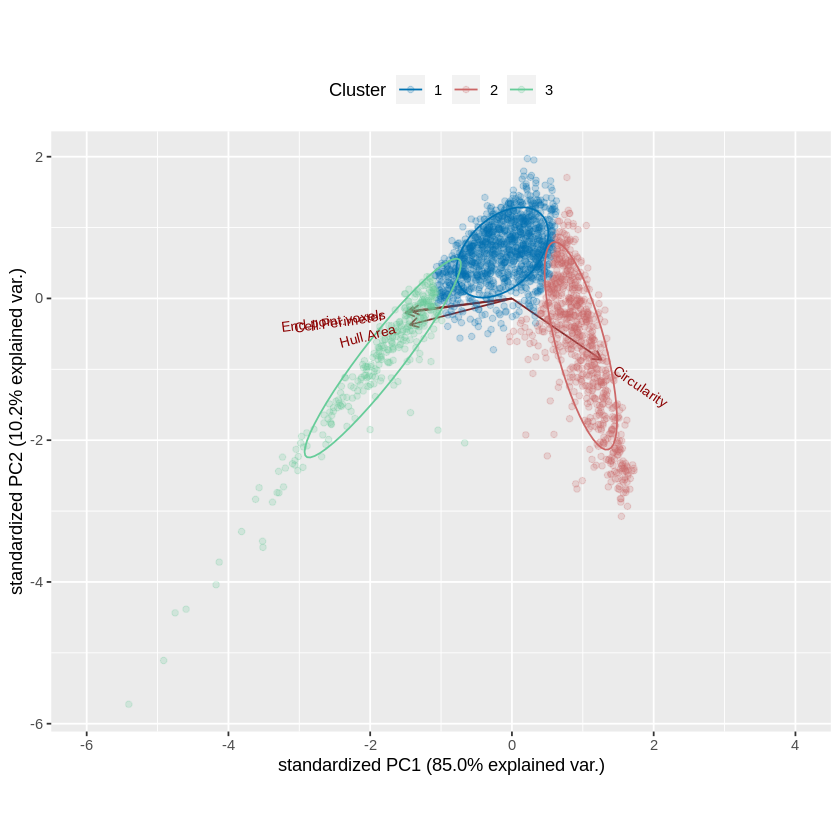

In [6]:
shhh(ggbiplot(pca.data, choices = 1:2, alpha = 0.2, ellipse = TRUE, 
groups = clust.id) + scale_color_manual(name="Cluster", 
values=c("#0072B2","#CC6666","#66CC99")) +
theme(legend.direction ="horizontal", legend.position = "top") +
xlim(c(-6,4)))

#### Counting cluster

In [77]:
# construir um 'data' com a classificação por celula
cluster <- data.frame(Cluster = clust.id)
data.cluster <- as.data.frame(c(data[,1:4],cluster,data[,5:23]))

# soma de celulas/cluster
reduced.data.cluster <- data.cluster[,1:5]

summary.cluster.all    <- reduced.data.cluster %>% 
                            group_by(Grupo,Animal,Cluster) %>% 
                            dplyr::summarise(Number.per.cluster = n())
summary.cluster.region <- reduced.data.cluster %>% 
                            group_by(Grupo,Animal,Region,Cluster) %>% 
                            dplyr::summarise(Number.per.cluster = n())

summary.cluster.CA3    <- filter(summary.cluster.region, Region == "CA3")

# filtrar celulas de fora do hipocampo em CA3
id.to.remove.ca3 <- read.csv("~/Documents/jupyter-workplace/laser-anoxia/microglia-morphology/data-processing/_m/id-to-remove-ca3.csv")

f.reduced.data.cluster <- reduced.data.cluster[-id.to.remove.ca3$id,]

f.summary.cluster.CA3 <- f.reduced.data.cluster %>% 
                            filter(Region == "CA3") %>%
                            group_by(Grupo,Animal,Region,Cluster) %>% 
                            dplyr::summarise(Number.per.cluster = n())

# write.csv(f.summary.cluster.CA3,"filtered-cluster-ca3.csv")

`summarise()` has grouped output by 'Grupo', 'Animal'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'Grupo', 'Animal', 'Region'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'Grupo', 'Animal', 'Region'. You can override using the `.groups` argument.


#### Plot cluster by experimental group

In [52]:
# cluster number by experimental group
